# Analayze csv
## Read csv

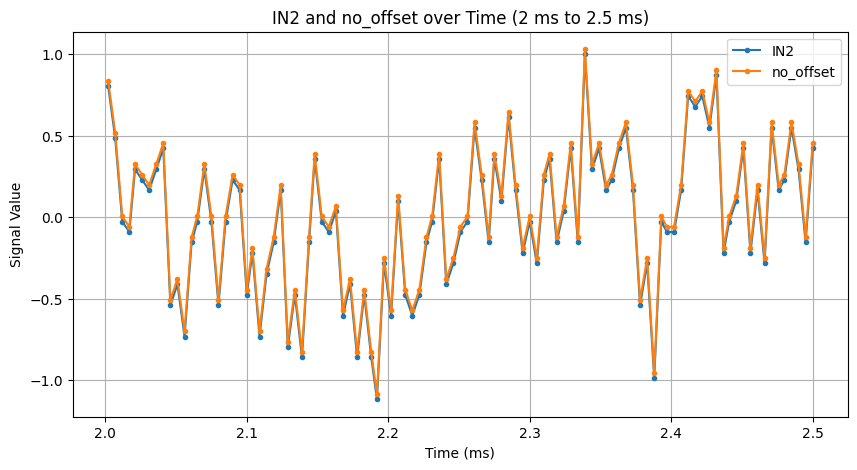

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = "data/scopeData01.csv"  # Update with your file path
df = pd.read_csv(file_path)


# Ensure time values are sorted in ascending order
df = df.sort_values(by="TIME ms")
df = df.reset_index(drop=True)

# Trim whitespace from column names
df.columns = df.columns.str.strip()

# Define time range (Modify these values to zoom in on a specific section)
start_time = 2   # Set the starting time in ms
end_time = 2.5     # Set the ending time in ms

# Filter data based on the selected time range
df_filtered = df[(df["TIME ms"] >= start_time) & (df["TIME ms"] <= end_time)]

# Plot IN2 and no_offset against TIME ms
plt.figure(figsize=(10, 5))
plt.plot(df_filtered["TIME ms"], df_filtered["IN2"], label="IN2", linestyle='-', marker='.')
plt.plot(df_filtered["TIME ms"], df_filtered["no_offset"], label="no_offset", linestyle='-', marker='.')

# Labels and title
plt.xlabel("Time (ms)")
plt.ylabel("Signal Value")
plt.title(f"IN2 and no_offset over Time ({start_time} ms to {end_time} ms)")
plt.legend()
plt.grid()

# Show the plot
plt.show()


## Show statistics

In [9]:
import numpy as np


# Function to compute statistics
def compute_statistics(df_section, section_name,column_name):
    stats = {
        "Section": section_name + " (" +column_name +")",
        "Number of Samples": len(df_section),
        # "Start Time (ms)": df_section["TIME ms"].min(),
        # "End Time (ms)": df_section["TIME ms"].max(),
        "Duration (ms)": df_section["TIME ms"].max() - df_section["TIME ms"].min(), 
        "Mean": df_section[column_name].mean(),
        "derivative Mean": np.mean(np.array(df_section[column_name][1:]) - np.array(df_section[column_name][:-1])),
        "Variance": df_section[column_name].var(),
        "derivative Variance": np.var(np.array(df_section[column_name][1:]) - np.array(df_section[column_name][:-1])),
        "Median": df_section[column_name].median(),
    }
    return stats

# Compute statistics for the whole signal and the selected section
stats_whole = [compute_statistics(df, "Whole Signal",col_name) for col_name in df.columns[1:]]
stats_section = [compute_statistics(df_filtered, f"Selected Section ({start_time} ms - {end_time} ms)",col_name) for col_name in df.columns[1:]]

# Convert statistics to a DataFrame for better display
stats_df = pd.DataFrame(stats_whole + stats_section)

# Display the statistics
df_to_display = pd.DataFrame(stats_df)

# Display the table in a Jupyter Notebook
from IPython.display import display
display(df_to_display)


,Section,Number of Samples,Duration (ms),Mean,derivative Mean,Variance,derivative Variance,Median
0,Whole Signal (IN2),1024,4.995,-3.155211e-02,0.000690,0.180368,0.175440,-0.026914
1,Whole Signal (no_offset),1024,4.995,-3.984375e-10,0.000690,0.180368,0.175440,0.004638
2,Selected Section (2 ms - 2.5 ms) (IN2),103,0.498,-1.195886e-02,-0.003775,0.190637,0.201107,-0.026914
3,Selected Section (2 ms - 2.5 ms) (no_offset),103,0.498,1.959324e-02,-0.003775,0.190637,0.201107,0.004638


## Show power spectrum

2025-03-24 22:44:38,642 - INFO - Sampling frequency (fs): 204804.80 Hz
2025-03-24 22:44:38,642 - INFO - Welch's method window size (nperseg): 256
2025-03-24 22:44:38,644 - INFO - Top 3 max power spectral values for IN2:
2025-03-24 22:44:38,644 - INFO -   1. Frequency: 2400.06 Hz, Power: 0.000026
2025-03-24 22:44:38,644 - INFO -   2. Frequency: 1600.04 Hz, Power: 0.000024
2025-03-24 22:44:38,645 - INFO -   3. Frequency: 15200.36 Hz, Power: 0.000013
2025-03-24 22:44:38,645 - INFO - Top 3 max power spectral values for no_offset:
2025-03-24 22:44:38,646 - INFO -   1. Frequency: 2400.06 Hz, Power: 0.000026
2025-03-24 22:44:38,646 - INFO -   2. Frequency: 1600.04 Hz, Power: 0.000024
2025-03-24 22:44:38,646 - INFO -   3. Frequency: 15200.36 Hz, Power: 0.000013


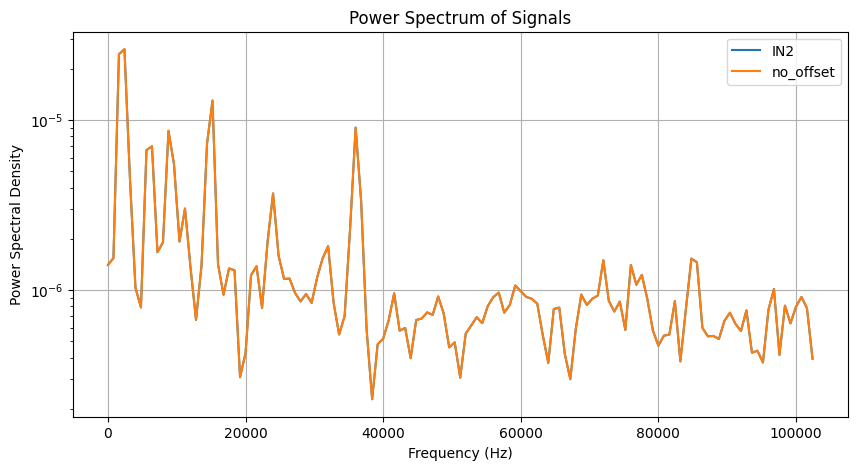

In [10]:
import numpy as np
import scipy.signal
import logging



# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

signal_columns = [col for col in df.columns if col != "TIME ms"]

# Define parameters
time_diff = np.mean(np.diff(df["TIME ms"]))  # Calculate time step
fs = 1 / (time_diff * 1e-3)  # Convert ms to seconds
nperseg = 256  # Window segment size for Welch's method

# Log the parameters used
logging.info(f"Sampling frequency (fs): {fs:.2f} Hz")
logging.info(f"Welch's method window size (nperseg): {nperseg}")
# Function to log the top three maximum values in the power spectrum
def log_top_max(signal, frequencies, power_spectrum,num_of_max):
    # Find indices of the top three maximum values
    top_indices = np.argsort(power_spectrum)[-num_of_max:][::-1]  # Get indices of top 3 in descending order
    top_freqs = frequencies[top_indices]  # Corresponding frequencies
    top_values = power_spectrum[top_indices]  # Corresponding PSD values

    # Log the results
    logging.info(f"Top 3 max power spectral values for {signal}:")
    for i in range(num_of_max):
        logging.info(f"  {i+1}. Frequency: {top_freqs[i]:.2f} Hz, Power: {top_values[i]:.6f}")



# Compute power spectrum for each signal
power_spectrum_results = {}
frequencies = None



for signal in signal_columns:
    freqs, psd = scipy.signal.welch(df[signal], fs=fs, nperseg=nperseg)
    power_spectrum_results[signal] = psd   # Add small offset to avoid log(0)
    if frequencies is None:
        frequencies = freqs

# Log the top three peaks for each signal
for signal in signal_columns:
    log_top_max(signal, frequencies, power_spectrum_results[signal],3)
    
# Plot power spectra
plt.figure(figsize=(10, 5))

for signal in signal_columns:
    plt.semilogy(frequencies, power_spectrum_results[signal], label=signal)

# Labels and title
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density")
plt.title("Power Spectrum of Signals")
plt.legend()
plt.grid()

# Show the plot
plt.show()



# Kalman filter

## test filterpy.kalman behavior

In [11]:
import filterpy.kalman as kf

x, P = kf.predict(x=10., P=3., u=1., Q=2.**2)
print(f'{x:.3f}')

# `x` is the state of the system.
# `P` is the variance of the system.
# `u` is the movement due to the process.
# `Q` is the noise in the process.
# You will need to used named arguments when you call `predict()` because most of the arguments are optional. The third argument to `predict()` is **not** `u`.

x, P = kf.update(x=x, P=P, z=12., R=3.5**2)
print(f'{x:.3f} {P:.3f}')

# `x` is the state of the system.
# `P` is the variance of the system.
# `z` is the measurement.
# `R` is the measurement variance.



11.000
11.364 4.455


## filterpy.kalman on csv 

In [12]:
col_name = "IN2"



P = 3 # initial variance of the system
x_col_name = 'x update (' + col_name + ')'
predict_col_name = 'x predict (' + col_name + ')'
x = 0
for idx,sample in enumerate(df[col_name]):
    x, P = kf.predict(x=x, P=P, u=1., Q=2.**2)
    x = np.array(sample) if idx == 0 else x 
    df.loc[idx, predict_col_name] = x 
    x, P = kf.update(x=x, P=P, z=sample, R=1.5**2)
    df.loc[idx, x_col_name] = x
    
display(df.head(4))

,TIME ms,IN2,no_offset,x predict (IN2),x update (IN2)
0,-2.495,-0.283642,-0.252090,-0.283642,-0.283642
1,-2.490,-0.283642,-0.252090,0.716358,-0.000719
2,-2.485,-0.925464,-0.893912,0.999281,-0.374727
3,-2.480,-0.797099,-0.765547,0.625273,-0.389734


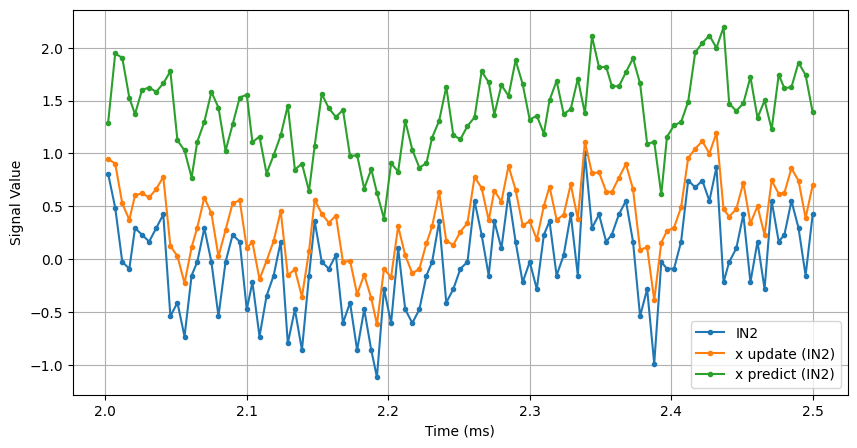

In [13]:
# Define time range (Modify these values to zoom in on a specific section)
start_time = 2   # Set the starting time in ms
end_time = 2.5     # Set the ending time in ms

# Filter data based on the selected time range
df_filtered = df[(df["TIME ms"] >= start_time) & (df["TIME ms"] <= end_time)]

# Plot IN2 and no_offset against TIME ms
plt.figure(figsize=(10, 5))
plt.plot(df_filtered["TIME ms"], df_filtered["IN2"], label="IN2", linestyle='-', marker='.')
plt.plot(df_filtered["TIME ms"], df_filtered[x_col_name], label=x_col_name, linestyle='-', marker='.')
plt.plot(df_filtered["TIME ms"], df_filtered[predict_col_name], label=predict_col_name, linestyle='-', marker='.')

# Labels and title
plt.xlabel("Time (ms)")
plt.ylabel("Signal Value")
# plt.title(f"IN2 and no_offset over Time ({start_time} ms to {end_time} ms)")
plt.legend()
plt.grid()

# Show the plot
plt.show()